# Lichess Dataset Analysis

In [25]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Read the dataset
df = pd.read_csv('games.csv')

# Convert into datetime
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms') 
df['last_move_at'] = pd.to_datetime(df['last_move_at'], unit='ms') 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              20058 non-null  object        
 1   rated           20058 non-null  bool          
 2   created_at      20058 non-null  datetime64[ns]
 3   last_move_at    20058 non-null  datetime64[ns]
 4   turns           20058 non-null  int64         
 5   victory_status  20058 non-null  object        
 6   winner          20058 non-null  object        
 7   increment_code  20058 non-null  object        
 8   white_id        20058 non-null  object        
 9   white_rating    20058 non-null  int64         
 10  black_id        20058 non-null  object        
 11  black_rating    20058 non-null  int64         
 12  moves           20058 non-null  object        
 13  opening_eco     20058 non-null  object        
 14  opening_name    20058 non-null  object        
 15  op

# Exploratory Data Analysis

## Class Imbalance

In [27]:
print('Percentage of Winners in the game')
class_imb = round(df['winner'].value_counts(normalize=True)*100, 2)
for ind in class_imb.index:
    print(f'{ind.capitalize()} = {class_imb[ind]} %')

print('\nNumber of Draw games = ', df['winner'].value_counts()['draw'])

Percentage of Winners in the game
White = 49.86 %
Black = 45.4 %
Draw = 4.74 %

Number of Draw games =  950


As `White` win and `Black` win percentages are close to each other, we can say that there is no class imbalance here. The `Draw` percentage is very small but the number of games is significant amount, so we will make observations in this as well

## Nature of Victory

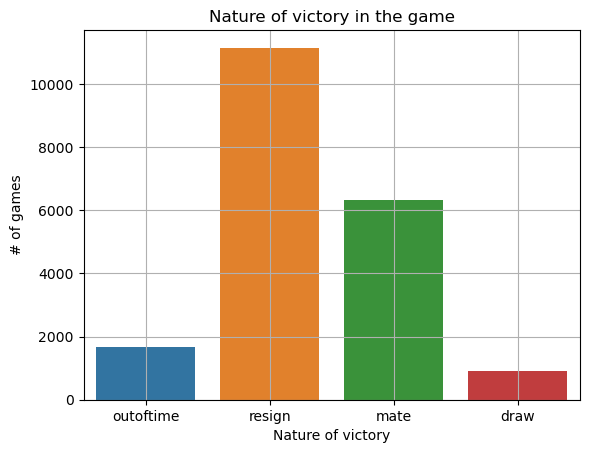

In [28]:
sns.countplot(data=df, x='victory_status')
plt.title('Nature of victory in the game')
plt.xlabel('Nature of victory')
plt.ylabel('# of games')
plt.grid(True)
plt.show()

It can be observed that players tend to resign than to continue until the end

### Is it the same in all formats of games

In [29]:
# Split increment_code:
df['base_time'] = df['increment_code'].str.split('+').str[0].astype(int)
df['increment_time'] = df['increment_code'].str.split('+').str[1].astype(int)
df.drop(columns='increment_code', inplace=True)

# categorize the games
conditions = [
    (df['base_time'] < 3),
    (df['base_time'] >= 3) & (df['base_time'] < 10),
    (df['base_time'] >= 10) & (df['base_time'] < 30),
    (df['base_time'] >= 30)
]

choices = ['Bullet', 'Blitz', 'Rapid', 'Classical']

df['format'] = np.select(conditions, choices, default='Unknown')

In [30]:
# Create a function to convert all into percentage
def percentage_df_generator_for_game_formats(column):
    plot_df = pd.DataFrame()

    for choice in choices:
        temp_df = df[df['format'] == choice]
        to_concat = round(temp_df[column].value_counts(normalize=True) * 100, 2)
        the_column = to_concat.index
        game_format = [choice for x in the_column]
        column_percentage = list(to_concat)
        concat_df = pd.DataFrame(zip(the_column, game_format, column_percentage))
        plot_df = pd.concat([plot_df, concat_df])
    return plot_df

In [ ]:
convert this into a stacked plot

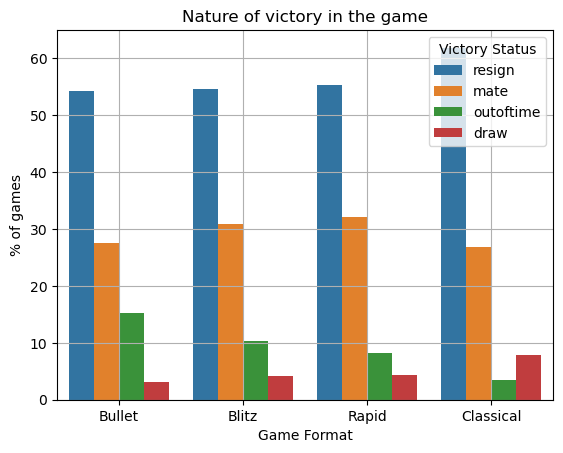

In [31]:
plot_df = percentage_df_generator_for_game_formats('victory_status')
plot_df.columns = ['victory_status', 'game_format', 'victory_status_percentage']
sns.barplot(data=plot_df, x='game_format', y='victory_status_percentage', hue='victory_status')
plt.title('Nature of victory in the game')
plt.xlabel('Game Format')
plt.ylabel('% of games')
plt.legend(title='Victory Status')
plt.grid(True)
plt.show()

Same behaviour can be observed in different formats of the game as well. A few observations are:
1. Players tend to draw more in Clasical format of the game
1. Classical format of the game has more time, so ending a match by running out of time is lesser
1. Players calulate a few moves ahead in classical format of the game, so the percentage of resignations is more here
1. Bullet is a faster format and so running out of time is more probable here than other games

## Rated vs Non-Rated

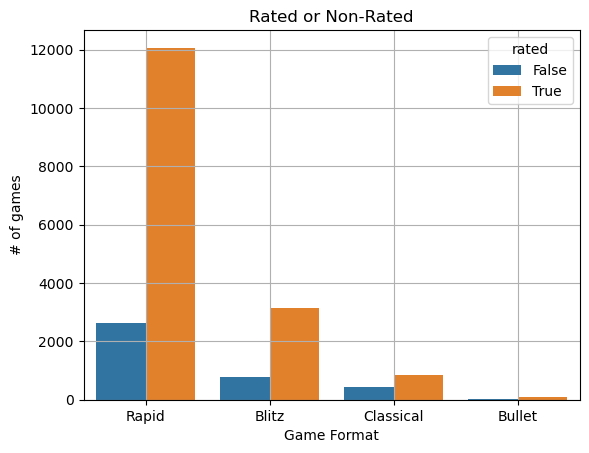

In [32]:
sns.countplot(data=df, x='format', hue='rated')
plt.title('Rated or Non-Rated')
plt.xlabel('Game Format')
plt.ylabel('# of games')
plt.grid(True)
plt.show()

In any format of the game, players prefer Rated games (where the outcome of the game effects their rating) indicating this is a serious platform

In [ ]:
# Convert this into a stacked plot

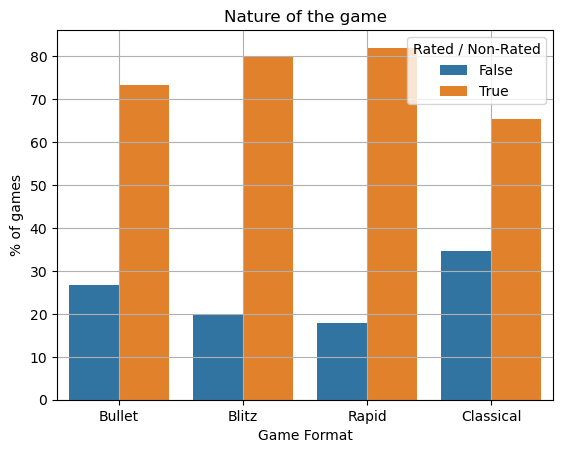

In [33]:
plot_df = percentage_df_generator_for_game_formats('rated')
plot_df.columns = ['rated', 'game_format', 'rated_percentage']
sns.barplot(data=plot_df, x='game_format', y='rated_percentage', hue='rated')
plt.title('Nature of the game')
plt.xlabel('Game Format')
plt.ylabel('% of games')
plt.legend(title='Rated / Non-Rated')
plt.grid(True)
plt.show()

## Beat the odds

In [34]:
# Is it common to beat a higher rated player in a particular format of the game

In [35]:
(((df['winner'] == 'white') & (df['white_rating'] < df['black_rating'])) | ((df['winner'] == 'black') & (df['black_rating'] < df['white_rating']))).sum()

6566

## Turns in a game

<Axes: xlabel='format', ylabel='count'>

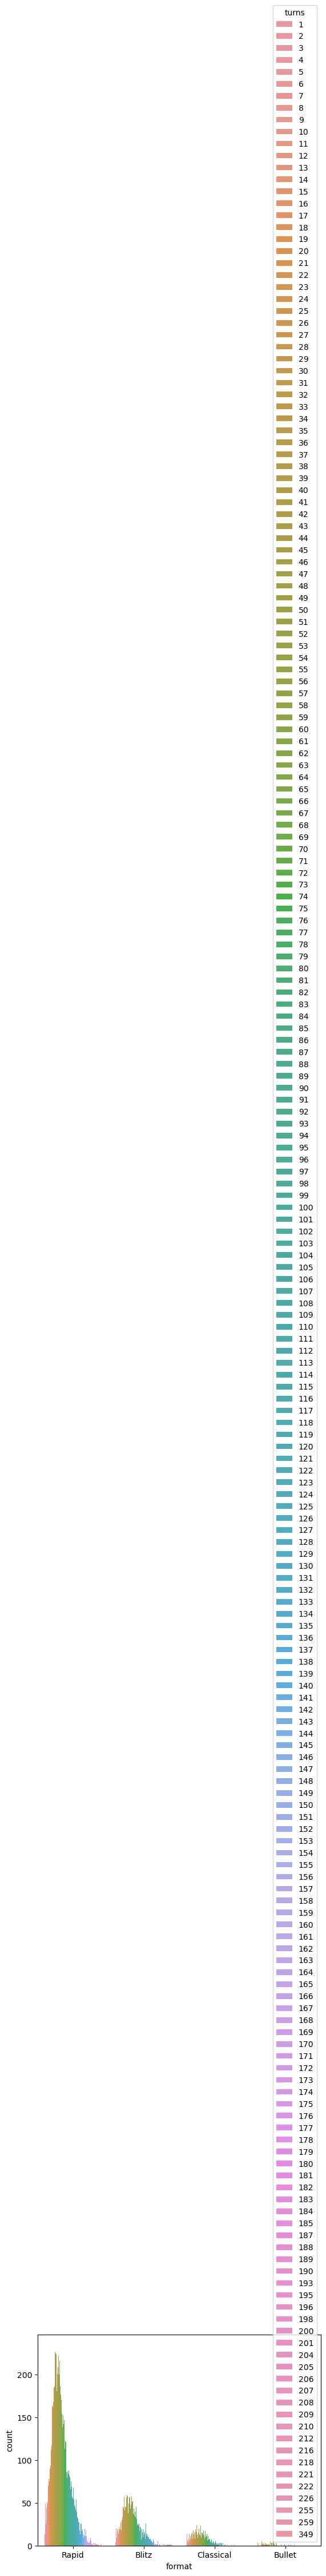

In [36]:
sns.countplot(data=df, x='format', hue='turns')

## Choice of player

<Axes: xlabel='white_rating', ylabel='black_rating'>

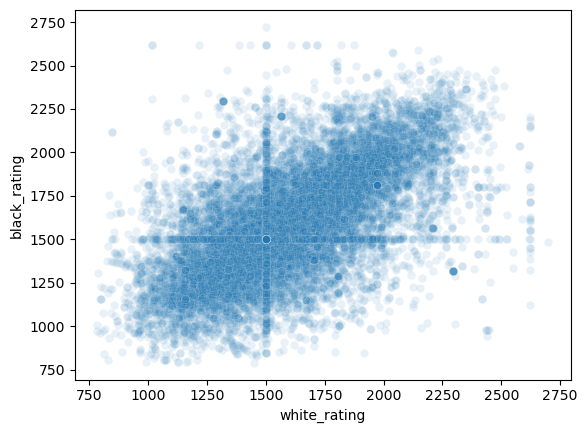

In [37]:
sns.scatterplot(data=df, x='white_rating', y='black_rating', alpha=0.1)

Games are generally between similar rated players as can be seen from the linear pattern, but there are also games where the difference in rating is large

## The unusual straight line

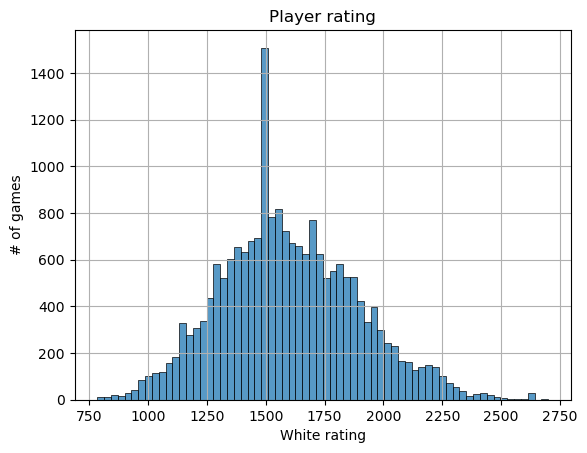

In [38]:
sns.histplot(data=df, x='white_rating')
plt.title('Player rating')
plt.xlabel('White rating')
plt.ylabel('# of games')
plt.grid(True)
plt.show()

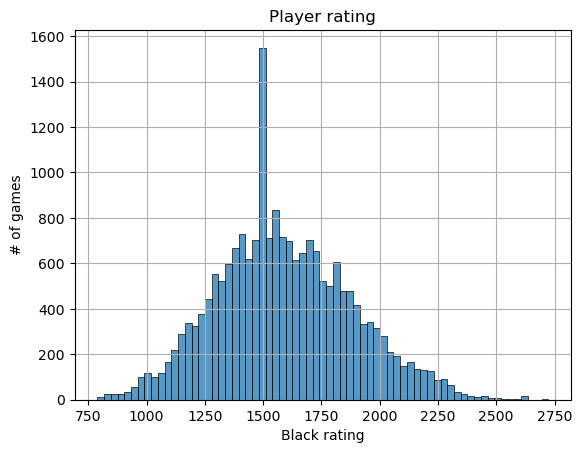

In [39]:
sns.histplot(data=df, x='black_rating')
plt.title('Player rating')
plt.xlabel('Black rating')
plt.ylabel('# of games')
plt.grid(True)
plt.show()

The graphs follow normal distribution which is expected. But the sudden spike at 1500 indicates that there are a lot of players with exactly that rating which is unusual. A new player is assigned the rating of 1500. Hence it cacn be concluded that there are a lot of new account creations in this platform